Toxicity Dataset : https://archive.ics.uci.edu/dataset/728/toxicity-2

The dataset includes 171 molecules designed for functional domains of a core clock protein, CRY1, responsible for generating circadian rhythm. 56 of the molecules are toxic and the rest are non-toxic. 

The data consists a complete set of 1203 molecular descriptors and needs feature selection before classification since some of the features are redundant. 

Introductory Paper:
Structure-based design and classifications of small molecules regulating the circadian rhythm period
By Seref Gul, F. Rahim, Safak Isin, Fatma Yilmaz, Nuri Ozturk, M. Turkay, I. Kavakli. 2021
https://www.semanticscholar.org/paper/Structure-based-design-and-classifications-of-small-Gul-Rahim/5944836c47bc7d1a2b0464a9a1db94d4bc7f28ce

# Imports

In [1]:
pip install ucimlrepo

In [2]:
import warnings
warnings.filterwarnings('ignore')
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from scipy import stats
from collections import Counter
import networkx as nx

from ucimlrepo import fetch_ucirepo 
from sklearn.base import BaseEstimator
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score,
    cross_validate, GridSearchCV, learning_curve, RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    precision_recall_curve, auc, roc_curve,
    classification_report, matthews_corrcoef,
    average_precision_score, balanced_accuracy_score, make_scorer,
    brier_score_loss, log_loss
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier,
    GradientBoostingClassifier, ExtraTreesClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn import clone
from scipy.stats import ttest_rel, wilcoxon
from statsmodels.stats.outliers_influence import variance_inflation_factor

from xgboost import XGBClassifier

# For SMOTE (install: pip install imbalanced-learn)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import tqdm
from typing import Dict, List, Optional, Union, Any, Tuple, Callable
from dataclasses import dataclass, field

In [3]:
# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11

In [4]:
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

In [5]:
# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Data loading and preprocessing

In [6]:
data = fetch_ucirepo(id=728)
X = data.data.features
y = data.data.targets

# Binary encoding: NonToxic=1, Toxic=0
y_binary = (y['Class'] == 'NonToxic').astype(int)

print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"Feature matrix shape: {X.shape}")
print(f"Number of molecules (n): {X.shape[0]}")
print(f"Number of descriptors (p): {X.shape[1]}")
print(f"Dimensionality ratio (p/n): {X.shape[1]/X.shape[0]:.2f}")
print(f"\nClass distribution:")
print(y['Class'].value_counts())
print(f"\nClass balance:")
for cls, count in y['Class'].value_counts().items():
    pct = count / len(y) * 100
    print(f"  {cls}: {count} ({pct:.2f}%)")

DATASET OVERVIEW
Feature matrix shape: (171, 1203)
Number of molecules (n): 171
Number of descriptors (p): 1203
Dimensionality ratio (p/n): 7.04

Class distribution:
Class
NonToxic    115
Toxic        56
Name: count, dtype: int64

Class balance:
  NonToxic: 115 (67.25%)
  Toxic: 56 (32.75%)


In [7]:
# Check for missing values
print(f"\nMissing values in features: {X.isnull().sum().sum()}")
print(f"Missing values in target: {y_binary.isnull().sum()}")


Missing values in features: 0
Missing values in target: 0


In [8]:
original_features = ['MDEC-23', 'MATS2v', 'ATSC8s', 'VE3_Dt', 'CrippenMR', 
                    'SpMax7_Bhe', 'SpMin1_Bhs', 'C1SP2', 'GATS8e', 'GATS8s', 
                    'SpMax5_Bhv', 'VE3_Dzi', 'VPC-4']

# Feature Correlation Analysis

ADVANCED MULTICOLLINEARITY DIAGNOSTICS

1. GLOBAL STABILITY ANALYSIS
   - Condition Number: 1.54e+06
   - Effective Rank (Eigenvalues > 1e-5): 170 / 1203
   -> DIAGNOSIS: Catastrophic Multicollinearity (Ill-conditioned matrix)

2. PAIRWISE REDUNDANCY (r > 0.9)
   - Total Correlated Pairs: 3702
   - Redundant Feature Groups (Clusters): 177
   - Example Largest Cluster (Size 228): ['SpAbs_Dzm', 'ATS3p', 'SpMin5_Bhv', 'SpMax6_Bhm', 'piPC4']...

3. VARIANCE INFLATION FACTOR (VIF) ANALYSIS
   Calculating VIF for all features (this may take a moment)...
   - Severity: 51.0% of features (613/1203) have VIF > 10.0
   - Mean VIF: -12332338171494188375985109793319103234048.00
   - Max VIF:  4755667454624034510111506432.00 (Feature: nF8HeteroRing)


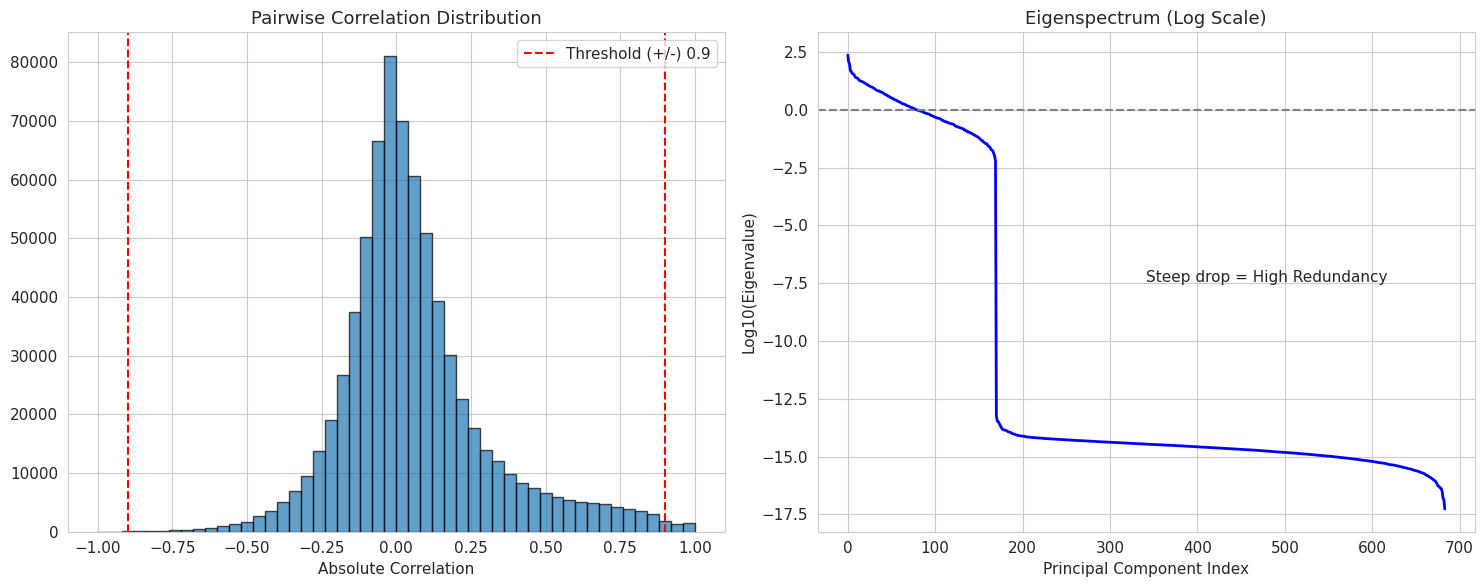

In [ ]:
def analyze_multicollinearity_advanced(X, corr_threshold=0.9, vif_threshold=10.0):
    """
    Comprehensive multicollinearity analysis including Pairwise, VIF, and Eigenvalue diagnostics.
    """
    print(f"{'='*80}")
    print(f"ADVANCED MULTICOLLINEARITY DIAGNOSTICS")
    print(f"{'='*80}\n")
    
    n_features = X.shape[1]
    
    # ---------------------------------------------------------
    # 1. Eigenvalue Analysis (Condition Number)
    # ---------------------------------------------------------
    # A condition number > 30 indicates moderate to severe multicollinearity
    # A very high number confirms "mathematically degenerate" matrix
    corr_matrix = X.corr()
    eigenvalues = np.linalg.eigvalsh(corr_matrix)
    condition_number = np.sqrt(eigenvalues.max() / (eigenvalues.min() + 1e-10)) # Avoid div by 0
    
    print(f"1. GLOBAL STABILITY ANALYSIS")
    print(f"   - Condition Number: {condition_number:.2e}")
    print(f"   - Effective Rank (Eigenvalues > 1e-5): {np.sum(eigenvalues > 1e-5)} / {n_features}")
    if condition_number > 100:
        print("   -> DIAGNOSIS: Catastrophic Multicollinearity (Ill-conditioned matrix)")
    
    # ---------------------------------------------------------
    # 2. Pairwise Correlation & Grouping (Graph Theory)
    # ---------------------------------------------------------
    # Instead of just listing pairs, we group them into "communities" of redundant features
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_pairs = upper.stack()
    high_corr_pairs = high_corr_pairs[high_corr_pairs.abs() > corr_threshold]
    
    # Create a graph of correlations
    G = nx.Graph()
    for (f1, f2), val in high_corr_pairs.items():
        G.add_edge(f1, f2, weight=val)
    
    components = list(nx.connected_components(G))
    
    print(f"\n2. PAIRWISE REDUNDANCY (r > {corr_threshold})")
    print(f"   - Total Correlated Pairs: {len(high_corr_pairs)}")
    print(f"   - Redundant Feature Groups (Clusters): {len(components)}")
    
    # Show largest cluster example
    if components:
        largest_cluster = max(components, key=len)
        print(f"   - Example Largest Cluster (Size {len(largest_cluster)}): {list(largest_cluster)[:5]}...")

    # ---------------------------------------------------------
    # 3. Variance Inflation Factor (VIF)
    # ---------------------------------------------------------
    # Note: This can be slow for very large N. We use a progress update.
    print(f"\n3. VARIANCE INFLATION FACTOR (VIF) ANALYSIS")
    print("   Calculating VIF for all features (this may take a moment)...")
    
    # Handle infinite VIF by catching errors or checking perfect correlation
    vif_data = []
    
    # We use the correlation matrix inverse diagonal for efficiency if N is large
    # VIF_i = 1 / (1 - R_i^2) = Diagonal of Inverse Correlation Matrix
    try:
        inv_corr = np.linalg.inv(corr_matrix.values)
        vif_values = np.diag(inv_corr)
        vif_series = pd.Series(vif_values, index=corr_matrix.index)
    except np.linalg.LinAlgError:
        print("   ! Matrix is singular. Using pseudo-inverse (approximate VIF).")
        inv_corr = np.linalg.pinv(corr_matrix.values)
        vif_series = pd.Series(np.diag(inv_corr), index=corr_matrix.index)

    # Statistics
    high_vif_count = (vif_series > vif_threshold).sum()
    pct_high_vif = (high_vif_count / n_features) * 100
    
    print(f"   - Severity: {pct_high_vif:.1f}% of features ({high_vif_count}/{n_features}) have VIF > {vif_threshold}")
    print(f"   - Mean VIF: {vif_series.mean():.2f}")
    print(f"   - Max VIF:  {vif_series.max():.2f} (Feature: {vif_series.idxmax()})")

    # ---------------------------------------------------------
    # 4. Visualization (Scree Plot + Histogram)
    # ---------------------------------------------------------
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Histogram of Correlations
    all_corrs = upper.values.flatten()
    all_corrs = all_corrs[~np.isnan(all_corrs)]
    ax1.hist(all_corrs, bins=50, edgecolor='black', alpha=0.7)
    ax1.axvline(corr_threshold, color='red', linestyle='--', label=f'Threshold (+/-) {corr_threshold}')
    ax1.axvline(-corr_threshold, color='red', linestyle='--')
    ax1.set_title('Pairwise Correlation Distribution')
    ax1.set_xlabel('Absolute Correlation')
    ax1.legend()
    
    # Scree Plot (Log Eigenvalues)
    ax2.plot(np.arange(len(eigenvalues)), np.log10(eigenvalues[::-1]), 'b-', linewidth=2)
    ax2.axhline(0, color='gray', linestyle='--')
    ax2.set_title('Eigenspectrum (Log Scale)')
    ax2.set_xlabel('Principal Component Index')
    ax2.set_ylabel('Log10(Eigenvalue)')
    ax2.text(0.5, 0.5, 'Steep drop = High Redundancy', transform=ax2.transAxes)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'high_corr_pairs': high_corr_pairs,
        'vif_data': vif_series,
        'condition_number': condition_number
    }

mc_diag = analyze_multicollinearity_advanced(X)

# Train-Test Split with Stratification

In [10]:
# Shuffle dataset
np.random.seed(RANDOM_STATE)
shuffle_idx = np.random.permutation(len(X))
X_shuffled = X.iloc[shuffle_idx].reset_index(drop=True)
y_shuffled = y_binary.iloc[shuffle_idx].reset_index(drop=True)

# Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_shuffled, y_shuffled, test_size=0.2,
    random_state=RANDOM_STATE, stratify=y_shuffled
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n{'='*80}")
print("TRAIN-TEST SPLIT")
print("="*80)
print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"\nTraining class distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nTest class distribution:")
print(pd.Series(y_test).value_counts())

feature_names = X.columns.tolist()


TRAIN-TEST SPLIT
Training set: (136, 1203)
Test set: (35, 1203)

Training class distribution:
Class
1    91
0    45
Name: count, dtype: int64

Test class distribution:
Class
1    24
0    11
Name: count, dtype: int64


In [11]:
# Compute class weights for weighted models
class_weights = compute_class_weight('balanced', 
                                     classes=np.unique(y_train), 
                                     y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"\n{'='*80}")
print("CLASS WEIGHTS")
print("="*80)
print(f"Class 0 (Toxic): {class_weight_dict[0]:.3f}")
print(f"Class 1 (NonToxic): {class_weight_dict[1]:.3f}")


CLASS WEIGHTS
Class 0 (Toxic): 1.511
Class 1 (NonToxic): 0.747


# SMOTE for Class Imbalance

In [12]:
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"\n{'='*80}")
print("SMOTE RESAMPLING")
print("="*80)
print(f"Original training size: {X_train_scaled.shape}")
print(f"SMOTE training size: {X_train_smote.shape}")
print(f"\nOriginal class distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nSMOTE class distribution:")
print(pd.Series(y_train_smote).value_counts())


SMOTE RESAMPLING
Original training size: (136, 1203)
SMOTE training size: (182, 1203)

Original class distribution:
Class
1    91
0    45
Name: count, dtype: int64

SMOTE class distribution:
Class
0    91
1    91
Name: count, dtype: int64


# Model Definitions and Hyperparameter Grids

In [13]:
models = {
    # ===== PENALIZED REGRESSION MODELS =====
    # No penalty
    'LR_No_Penalty': LogisticRegression(penalty=None, max_iter=5000, 
                                        solver='lbfgs', random_state=RANDOM_STATE),
    
    # Ridge (L2) - Multiple C values
    'LR_Ridge_C0.01': LogisticRegression(penalty='l2', C=0.01, max_iter=5000,
                                         solver='lbfgs', random_state=RANDOM_STATE),
    'LR_Ridge_C0.1': LogisticRegression(penalty='l2', C=0.1, max_iter=5000,
                                        solver='lbfgs', random_state=RANDOM_STATE),
    'LR_Ridge_C1': LogisticRegression(penalty='l2', C=1.0, max_iter=5000,
                                      solver='lbfgs', random_state=RANDOM_STATE),
    'LR_Ridge_C10': LogisticRegression(penalty='l2', C=10.0, max_iter=5000,
                                       solver='lbfgs', random_state=RANDOM_STATE),
    'LR_Ridge_C100': LogisticRegression(penalty='l2', C=100.0, max_iter=5000,
                                        solver='lbfgs', random_state=RANDOM_STATE),
    
    # Lasso (L1) - Multiple C values
    'LR_Lasso_C0.001': LogisticRegression(penalty='l1', C=0.001, max_iter=5000,
                                          solver='saga', random_state=RANDOM_STATE),
    'LR_Lasso_C0.01': LogisticRegression(penalty='l1', C=0.01, max_iter=5000,
                                         solver='saga', random_state=RANDOM_STATE),
    'LR_Lasso_C0.1': LogisticRegression(penalty='l1', C=0.1, max_iter=5000,
                                        solver='saga', random_state=RANDOM_STATE),
    'LR_Lasso_C1': LogisticRegression(penalty='l1', C=1.0, max_iter=5000,
                                      solver='saga', random_state=RANDOM_STATE),
    'LR_Lasso_C10': LogisticRegression(penalty='l1', C=10.0, max_iter=5000,
                                       solver='saga', random_state=RANDOM_STATE),
    
    # Elastic Net - Multiple configurations
    'LR_ElasticNet_L1_0.3_C0.1': LogisticRegression(penalty='elasticnet', solver='saga',
                                                     l1_ratio=0.3, C=0.1, max_iter=5000,
                                                     random_state=RANDOM_STATE),
    'LR_ElasticNet_L1_0.5_C0.1': LogisticRegression(penalty='elasticnet', solver='saga',
                                                     l1_ratio=0.5, C=0.1, max_iter=5000,
                                                     random_state=RANDOM_STATE),
    'LR_ElasticNet_L1_0.5_C1': LogisticRegression(penalty='elasticnet', solver='saga',
                                                   l1_ratio=0.5, C=1.0, max_iter=5000,
                                                   random_state=RANDOM_STATE),
    'LR_ElasticNet_L1_0.7_C1': LogisticRegression(penalty='elasticnet', solver='saga',
                                                   l1_ratio=0.7, C=1.0, max_iter=5000,
                                                   random_state=RANDOM_STATE),
    
    # Weighted versions of best regularized models
    'LR_Lasso_C0.1_Weighted': LogisticRegression(penalty='l1', C=0.1, max_iter=5000,
                                                 solver='saga', class_weight='balanced',
                                                 random_state=RANDOM_STATE),
    'LR_Ridge_C0.1_Weighted': LogisticRegression(penalty='l2', C=0.1, max_iter=5000,
                                                 solver='lbfgs', class_weight='balanced',
                                                 random_state=RANDOM_STATE),
    
    # Other linear classifiers
    'Ridge_Classifier': RidgeClassifier(alpha=1.0, random_state=RANDOM_STATE),
    'SGD_Classifier': SGDClassifier(loss='log_loss', max_iter=5000, 
                                   random_state=RANDOM_STATE),

    # ===== DISCRIMINANT ANALYSIS =====
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),

    # ===== NAIVE BAYES =====
    'Naive_Bayes': GaussianNB(),

    # ===== TREE-BASED MODELS =====
    'Decision_Tree_D5': DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE),
    'Decision_Tree_D10': DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE),
    'Decision_Tree_D20': DecisionTreeClassifier(max_depth=20, random_state=RANDOM_STATE),
    'Decision_Tree_Weighted': DecisionTreeClassifier(max_depth=10, 
                                                     class_weight='balanced',
                                                     random_state=RANDOM_STATE),

    # ===== ENSEMBLE METHODS =====
    # Random Forest
    'Random_Forest_N50': RandomForestClassifier(n_estimators=50, max_depth=10, 
                                                random_state=RANDOM_STATE),
    'Random_Forest_N100': RandomForestClassifier(n_estimators=100, max_depth=10,
                                                 random_state=RANDOM_STATE),
    'Random_Forest_N100_Weighted': RandomForestClassifier(n_estimators=100, max_depth=10,
                                                          class_weight='balanced',
                                                          random_state=RANDOM_STATE),
    'Extra_Trees_N100': ExtraTreesClassifier(n_estimators=100, max_depth=10,
                                            random_state=RANDOM_STATE),

    # Boosting
    'AdaBoost_N50': AdaBoostClassifier(n_estimators=50, random_state=RANDOM_STATE,
                                       algorithm='SAMME'),
    'AdaBoost_N100': AdaBoostClassifier(n_estimators=100, random_state=RANDOM_STATE,
                                        algorithm='SAMME'),
    'GradientBoosting_N50': GradientBoostingClassifier(n_estimators=50, max_depth=3,
                                                       random_state=RANDOM_STATE),
    'GradientBoosting_N100': GradientBoostingClassifier(n_estimators=100, max_depth=3,
                                                        random_state=RANDOM_STATE),
    'XGBoost_D3_N50': XGBClassifier(max_depth=3, n_estimators=50,
                                   eval_metric='logloss', use_label_encoder=False,
                                   random_state=RANDOM_STATE),
    'XGBoost_D3_N100': XGBClassifier(max_depth=3, n_estimators=100,
                                    eval_metric='logloss', use_label_encoder=False,
                                    random_state=RANDOM_STATE),

    # ===== SUPPORT VECTOR MACHINES =====
    'SVM_Linear': SVC(kernel='linear', probability=True, random_state=RANDOM_STATE),
    'SVM_Linear_Weighted': SVC(kernel='linear', probability=True, 
                              class_weight='balanced', random_state=RANDOM_STATE),
    'SVM_RBF_C1': SVC(kernel='rbf', C=1.0, probability=True, random_state=RANDOM_STATE),
    'SVM_RBF_C10': SVC(kernel='rbf', C=10.0, probability=True, random_state=RANDOM_STATE),
    'SVM_Poly_D2': SVC(kernel='poly', degree=2, probability=True, random_state=RANDOM_STATE),
    'SVM_Poly_D3': SVC(kernel='poly', degree=3, probability=True, random_state=RANDOM_STATE),

    # ===== K-NEAREST NEIGHBORS =====
    'KNN_K3': KNeighborsClassifier(n_neighbors=3),
    'KNN_K5': KNeighborsClassifier(n_neighbors=5),
    'KNN_K7': KNeighborsClassifier(n_neighbors=7),
    'KNN_K10': KNeighborsClassifier(n_neighbors=10),

    # ===== NEURAL NETWORKS =====
    'NN_Small': MLPClassifier(hidden_layer_sizes=(25,), max_iter=2000,
                             early_stopping=True, solver='lbfgs', 
                             random_state=RANDOM_STATE),
    'NN_Medium': MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=2000,
                              early_stopping=True, solver='lbfgs',
                              random_state=RANDOM_STATE),
    'NN_Large': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=2000,
                             early_stopping=True, solver='lbfgs',
                             random_state=RANDOM_STATE),
    'NN_Adam': MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=2000,
                            early_stopping=True, solver='adam',
                            random_state=RANDOM_STATE),
}

print(f"\nTotal models defined: {len(models)}")


Total models defined: 50


# Train and Evaluate Models

In [14]:
def evaluate_model_comprehensive(model, X_train, X_test, y_train, y_test, 
                                model_name="Model"):
    """
    Comprehensive evaluation including:
    - Standard metrics (accuracy, precision, recall, F1, AUC)
    - Matthews Correlation Coefficient (MCC)
    - Confusion matrix
    - Probability calibration check
    """
    # Fit model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Probability scores
    if hasattr(model, 'predict_proba'):
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_train_proba = model.decision_function(X_train)
        y_test_proba = model.decision_function(X_test)
    else:
        y_train_proba = y_train_pred.astype(float)
        y_test_proba = y_test_pred.astype(float)
    
    # Calculate metrics
    results = {
        'model': model_name,
        'train_acc': accuracy_score(y_train, y_train_pred),
        'test_acc': accuracy_score(y_test, y_test_pred),
        'train_auc': roc_auc_score(y_train, y_train_proba),
        'test_auc': roc_auc_score(y_test, y_test_proba),
        'precision': precision_score(y_test, y_test_pred, zero_division=0),
        'recall': recall_score(y_test, y_test_pred, zero_division=0),
        'f1': f1_score(y_test, y_test_pred, zero_division=0),
        'mcc': matthews_corrcoef(y_test, y_test_pred),
        'pr_auc': average_precision_score(y_test, y_test_proba),
        'bacc': balanced_accuracy_score(y_test, y_test_pred)
    }
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Specificity, Sensitivity, NPV
    results['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    results['sensitivity'] = tp / (tp + fn) if (tp + fn) > 0 else 0
    results['npv'] = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    # Check for majority class prediction
    unique_preds = np.unique(y_test_pred)
    results['predicts_one_class'] = len(unique_preds) == 1
    
    return results, cm

## STANDARD TRAIN-TEST SPLIT

In [ ]:
print("\n" + "="*80)
print("TRAINING MODELS - STANDARD TRAIN-TEST SPLIT")
print("="*80)

results_standard = []
confusion_matrices = {}

for name, model in models.items():
    print(f"Training {name}...", end=" ")
    try:
        metrics, cm = evaluate_model_comprehensive(
            model, X_train_scaled, X_test_scaled, y_train, y_test, name
        )
        results_standard.append(metrics)
        confusion_matrices[name] = cm
        
        # Flag models predicting only one class
        flag = " [⚠ ONE CLASS]" if metrics['predicts_one_class'] else ""
        print(f"mcc: {metrics['mcc']:.4f}, pr_auc: {metrics['pr_auc']:.4f}, bacc: {metrics['bacc']:.4f}{flag}")
    except Exception as e:
        print(f"FAILED: {e}")

results_standard_df = pd.DataFrame(results_standard).sort_values('mcc', ascending=False).reset_index(drop=True)

In [ ]:
results_standard_df

,model,train_acc,test_acc,train_auc,test_auc,precision,recall,f1,mcc,pr_auc,bacc,specificity,sensitivity,npv,predicts_one_class
0,QDA,1.000000,0.628571,1.000000,0.630682,0.789474,0.625000,0.697674,0.243562,0.750564,0.630682,0.636364,0.625000,0.437500,False
1,XGBoost_D3_N50,1.000000,0.657143,1.000000,0.689394,0.750000,0.750000,0.750000,0.204545,0.866304,0.602273,0.454545,0.750000,0.454545,False
2,KNN_K3,0.757353,0.657143,0.779487,0.695076,0.750000,0.750000,0.750000,0.204545,0.825753,0.602273,0.454545,0.750000,0.454545,False
3,Decision_Tree_D5,0.948529,0.628571,0.989866,0.579545,0.761905,0.666667,0.711111,0.201008,0.719526,0.606061,0.545455,0.666667,0.428571,False
4,Random_Forest_N100_Weighted,1.000000,0.685714,1.000000,0.678030,0.724138,0.875000,0.792453,0.181965,0.867135,0.573864,0.272727,0.875000,0.500000,False
5,KNN_K10,0.654412,0.657143,0.682051,0.655303,0.730769,0.791667,0.760000,0.164958,0.806430,0.577652,0.363636,0.791667,0.444444,False
6,GradientBoosting_N100,1.000000,0.657143,1.000000,0.625000,0.730769,0.791667,0.760000,0.164958,0.833974,0.577652,0.363636,0.791667,0.444444,False
7,XGBoost_D3_N100,1.000000,0.657143,1.000000,0.681818,0.730769,0.791667,0.760000,0.164958,0.865483,0.577652,0.363636,0.791667,0.444444,False
8,LDA,0.955882,0.600000,0.993407,0.547348,0.750000,0.625000,0.681818,0.159901,0.708999,0.585227,0.545455,0.625000,0.400000,False
9,Decision_Tree_D20,1.000000,0.600000,1.000000,0.585227,0.750000,0.625000,0.681818,0.159901,0.725893,0.585227,0.545455,0.625000,0.400000,False


## With SMOTE Resampling

In [ ]:
print("\n" + "="*80)
print("TRAINING MODELS - WITH SMOTE RESAMPLING")
print("="*80)

results_smote = []

for name, model in models.items():
    # Skip if model doesn't work well with SMOTE
    if 'LDA' in name or 'QDA' in name:
        continue
        
    print(f"Training {name} with SMOTE...", end=" ")
    try:
        metrics, cm = evaluate_model_comprehensive(
            model, X_train_smote, X_test_scaled, y_train_smote, y_test, 
            f"{name}_SMOTE"
        )
        results_smote.append(metrics)
        
        flag = " [⚠ ONE CLASS]" if metrics['predicts_one_class'] else ""
        print(f"mcc: {metrics['mcc']:.4f}, pr_auc: {metrics['pr_auc']:.4f}, bacc: {metrics['bacc']:.4f}{flag}")
    except Exception as e:
        print(f"FAILED: {e}")

results_smote_df = pd.DataFrame(results_smote).sort_values('mcc', ascending=False).reset_index(drop=True)


TRAINING MODELS - WITH SMOTE RESAMPLING
Training LR_No_Penalty with SMOTE... mcc: 0.1599, pr_auc: 0.7446, bacc: 0.5852
Training LR_Ridge_C0.01 with SMOTE... mcc: 0.0296, pr_auc: 0.7354, bacc: 0.5152
Training LR_Ridge_C0.1 with SMOTE... mcc: -0.0606, pr_auc: 0.7836, bacc: 0.4697
Training LR_Ridge_C1 with SMOTE... mcc: 0.0296, pr_auc: 0.7703, bacc: 0.5152
Training LR_Ridge_C10 with SMOTE... mcc: -0.0606, pr_auc: 0.7663, bacc: 0.4697
Training LR_Ridge_C100 with SMOTE... mcc: -0.0109, pr_auc: 0.7645, bacc: 0.4943
Training LR_Lasso_C0.001 with SMOTE... mcc: 0.0000, pr_auc: 0.6857, bacc: 0.5000 [⚠ ONE CLASS]
Training LR_Lasso_C0.01 with SMOTE... mcc: 0.0000, pr_auc: 0.6857, bacc: 0.5000 [⚠ ONE CLASS]
Training LR_Lasso_C0.1 with SMOTE... mcc: -0.0503, pr_auc: 0.7002, bacc: 0.4735
Training LR_Lasso_C1 with SMOTE... mcc: 0.0296, pr_auc: 0.7541, bacc: 0.5152
Training LR_Lasso_C10 with SMOTE... mcc: 0.0296, pr_auc: 0.7457, bacc: 0.5152
Training LR_ElasticNet_L1_0.3_C0.1 with SMOTE... mcc: 0.1165

In [ ]:
results_smote_df

,model,train_acc,test_acc,train_auc,test_auc,precision,recall,f1,mcc,pr_auc,bacc,specificity,sensitivity,npv,predicts_one_class
0,Decision_Tree_Weighted_SMOTE,1.000000,0.714286,1.000000,0.693182,0.818182,0.750000,0.782609,0.371206,0.785065,0.693182,0.636364,0.750000,0.538462,False
1,Decision_Tree_D10_SMOTE,1.000000,0.714286,1.000000,0.693182,0.818182,0.750000,0.782609,0.371206,0.785065,0.693182,0.636364,0.750000,0.538462,False
2,Decision_Tree_D20_SMOTE,1.000000,0.714286,1.000000,0.693182,0.818182,0.750000,0.782609,0.371206,0.785065,0.693182,0.636364,0.750000,0.538462,False
3,Decision_Tree_D5_SMOTE,0.928571,0.685714,0.947470,0.715909,0.842105,0.666667,0.744186,0.367109,0.792992,0.696970,0.727273,0.666667,0.500000,False
4,KNN_K3_SMOTE,0.769231,0.542857,0.928149,0.645833,0.833333,0.416667,0.555556,0.229686,0.790580,0.617424,0.818182,0.416667,0.391304,False
5,SVM_Poly_D3_SMOTE,0.785714,0.400000,0.979230,0.541667,1.000000,0.125000,0.222222,0.207289,0.762223,0.562500,1.000000,0.125000,0.343750,False
6,NN_Small_SMOTE,1.000000,0.657143,1.000000,0.672348,0.750000,0.750000,0.750000,0.204545,0.832904,0.602273,0.454545,0.750000,0.454545,False
7,GradientBoosting_N50_SMOTE,1.000000,0.600000,1.000000,0.689394,0.777778,0.583333,0.666667,0.204063,0.862702,0.609848,0.636364,0.583333,0.411765,False
8,AdaBoost_N50_SMOTE,1.000000,0.628571,1.000000,0.609848,0.761905,0.666667,0.711111,0.201008,0.820031,0.606061,0.545455,0.666667,0.428571,False
9,SVM_Poly_D2_SMOTE,0.868132,0.571429,0.966308,0.632576,0.764706,0.541667,0.634146,0.165362,0.815875,0.589015,0.636364,0.541667,0.388889,False


In [ ]:
results_combined_df = pd.concat([results_standard_df, results_smote_df], 
                                ignore_index=True)
results_combined_df = results_combined_df.sort_values('mcc', 
                                                       ascending=False).reset_index(drop=True)

## Model Grouping for Analysis

In [ ]:
def assign_model_group(name):
    """Assign models to categories for grouped analysis"""
    if 'SMOTE' in name:
        return 'SMOTE Variants'
    elif any(k in name for k in ['LR_', 'Ridge_Classifier', 'SGD_Classifier']):
        return 'Linear / Penalized'
    elif 'Decision_Tree' in name and not any(x in name for x in ['Random', 'Extra']):
        return 'Single Tree'
    elif any(k in name for k in ['Random_Forest', 'Extra_Trees']):
        return 'Random Forest / ExtraTrees'
    elif any(k in name for k in ['AdaBoost', 'GradientBoosting', 'XGBoost']):
        return 'Boosting Ensembles'
    elif 'SVM_' in name:
        return 'SVM'
    elif 'KNN_' in name:
        return 'KNN'
    elif 'NN_' in name:
        return 'Neural Networks'
    elif name in ['LDA', 'QDA']:
        return 'Discriminant Analysis'
    elif name == 'Naive_Bayes':
        return 'Naive Bayes'
    else:
        return 'Other'

results_combined_df['Group'] = results_combined_df['model'].apply(assign_model_group)


## Visualizations

### Performance Comparison

In [ ]:
def plot_single_metric(results_df, n=15, metric='test_auc', title=None, figsize=(12, 10)):    
    # Validate metric exists
    available_metrics = results_df.columns.tolist()
    if metric not in available_metrics:
        raise ValueError(f"metric '{metric}' not found. Available: {available_metrics}")
    
    # Sort by metric and get top n
    top_n = results_df.nlargest(n, metric).copy()
    top_n = top_n.iloc[::-1]  # Reverse for better display
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Determine colors based on one-class prediction flag if available
    if 'predicts_one_class' in top_n.columns:
        colors = ['#2bbbdf' if not row['predicts_one_class'] else '#ff6b6b' 
                  for _, row in top_n.iterrows()]
    else:
        colors = '#2bbbdf'
    
    # ===== PLOT METRIC =====
    ax.barh(range(len(top_n)), top_n[metric], color=colors, alpha=0.8, 
            edgecolor='black', linewidth=0.5)
    ax.set_yticks(range(len(top_n)))
    ax.set_yticklabels(top_n['model'], fontsize=10)
    ax.set_xlabel(metric.replace('_', ' ').title(), fontsize=12, weight='bold')
    ax.set_title(f'{metric.replace("_", " ").title()} (Top {n} Models)', 
                 fontsize=14, weight='bold')
    
    # Set x-limits based on metric range
    if metric in ['test_acc', 'test_auc', 'precision', 'recall', 'f1', 'pr_auc', 
                  'bacc', 'sensitivity', 'specificity', 'npv', 'train_acc', 'train_auc']:
        ax.set_xlim(0, 1.0)
    
    ax.grid(axis='x', alpha=0.3)
    
    # ===== LEGEND =====
    if 'predicts_one_class' in top_n.columns:
        legend_elements = [
            Patch(facecolor='#2bbbdf', alpha=0.8, label='Valid predictions'),
            Patch(facecolor='#ff6b6b', alpha=0.8, label='One-class predictions')
        ]
        ax.legend(handles=legend_elements, loc='lower right', fontsize=10, 
                  framealpha=0.95, edgecolor='black')
    
    # ===== TITLE =====
    if title is None:
        title = f'Top {n} Models by {metric.upper()}'
    
    fig.suptitle(title, fontsize=16, weight='bold', y=0.995)
    
    plt.tight_layout()
    
    return fig


In [ ]:
# Example 1: Test AUC
fig1 = plot_single_metric(results_combined_df, n=15, metric='test_auc',
                          title='Top 15 Models: Test AUC')
plt.savefig('fig_top15_test_auc.png', dpi=300, bbox_inches='tight')
plt.show()

# Example 2: MCC
fig2 = plot_single_metric(results_combined_df, n=15, metric='mcc',
                          title='Top 15 Models: Matthews Correlation Coefficient')
plt.savefig('fig_top15_mcc.png', dpi=300, bbox_inches='tight')
plt.show()

# Example 3: F1 Score
fig3 = plot_single_metric(results_combined_df, n=15, metric='f1',
                          title='Top 15 Models: F1 Score')
plt.savefig('fig_top15_f1.png', dpi=300, bbox_inches='tight')
plt.show()

# Example 4: PR-AUC
fig4 = plot_single_metric(results_combined_df, n=15, metric='pr_auc',
                          title='Top 15 Models: Precision-Recall AUC')
plt.savefig('fig_top15_pr_auc.png', dpi=300, bbox_inches='tight')
plt.show()

# Example 5: Balanced Accuracy
fig5 = plot_single_metric(results_combined_df, n=20, metric='bacc',
                          title='Top 20 Models: Balanced Accuracy')
plt.savefig('fig_top20_bacc.png', dpi=300, bbox_inches='tight')
plt.show()

# Example 6: Sensitivity
fig6 = plot_single_metric(results_combined_df, n=15, metric='sensitivity',
                          title='Top 15 Models: Sensitivity (True Positive Rate)')
plt.savefig('fig_top15_sensitivity.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
def plot_train_test_scatter_enhanced(results_df):
    """Enhanced train vs test scatter with overfitting zones and improved visual design"""
    df_plot = results_df[~results_df['model'].str.contains('SMOTE')].copy()
    
    # Calculate overfitting gap for analysis
    df_plot['overfitting_gap'] = df_plot['train_acc'] - df_plot['test_acc']
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Color by group with improved palette
    groups = df_plot['Group'].unique()
    palette = sns.color_palette('husl', n_colors=len(groups))  # Better color distinction
    color_map = dict(zip(groups, palette))
    
    # Plot each group with enhanced styling
    for group in groups:
        group_data = df_plot[df_plot['Group'] == group]
        ax.scatter(group_data['train_acc'], group_data['test_acc'],
                  label=group, s=150, alpha=0.75,  # Larger markers
                  color=color_map[group], 
                  edgecolors='white', linewidth=1.5,  # White borders for better visibility
                  zorder=3)  # Ensure points are on top
    
    # Reference lines with improved styling
    ax.plot([0.5, 1], [0.5, 1], 'k--', alpha=0.5, linewidth=2.5, 
            label='Perfect Generalization', zorder=2)
    
    # Multiple overfitting zones for better interpretation
    ax.fill_between([0.5, 1], [0.45, 0.95], [0.5, 1], 
                    alpha=0.15, color='red', label='Severe Overfitting', zorder=1)
    ax.fill_between([0.5, 1], [0.475, 0.975], [0.5, 1], 
                    alpha=0.08, color='orange', label='Mild Overfitting', zorder=1)
    
    # Underfitting zone (below diagonal)
    ax.fill_between([0.5, 1], [0.5, 1], [0.55, 1.05], 
                    alpha=0.08, color='blue', label='Underfitting', zorder=1)
    
    # Annotate top 3 overfitters
    top_overfitters = df_plot.nlargest(3, 'overfitting_gap')
    for idx, row in top_overfitters.iterrows():
        ax.annotate(row['model'].split('_')[0],  # Shortened label
                   xy=(row['train_acc'], row['test_acc']),
                   xytext=(8, 8), textcoords='offset points',
                   fontsize=9, alpha=0.8,
                   bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.4),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', 
                                 alpha=0.6, lw=1))
    
    # Styling improvements
    ax.set_xlabel('Training Accuracy', fontsize=14, weight='semibold')
    ax.set_ylabel('Test Accuracy', fontsize=14, weight='semibold')
    ax.set_title('Model Generalization: Train vs Test Accuracy Analysis', 
                fontsize=16, weight='bold', pad=20)
    
    # Improved legend
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', 
             fontsize=10, framealpha=0.95, edgecolor='gray')
    
    # Set limits with padding
    ax.set_xlim(0.48, 1.02)
    ax.set_ylim(0.48, 1.02)
    
    # Enhanced grid
    ax.grid(alpha=0.25, linestyle='--', linewidth=0.5, zorder=0)
    ax.set_axisbelow(True)  # Grid behind all elements
    
    # Add minor ticks for better readability
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.025))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.025))
    
    # Background color
    ax.set_facecolor('#f8f8f8')
    
    plt.tight_layout()
    plt.savefig('fig_train_test_scatter.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.show()
    
    # Enhanced overfitting summary
    print("\n" + "="*90)
    print(" "*30 + "OVERFITTING ANALYSIS")
    print("="*90)
    
    print(f"\nDataset Statistics:")
    print(f"  Total models analyzed: {len(df_plot)}")
    print(f"  Mean overfitting gap: {df_plot['overfitting_gap'].mean():.4f}")
    print(f"  Median overfitting gap: {df_plot['overfitting_gap'].median():.4f}")
    print(f"  Std overfitting gap: {df_plot['overfitting_gap'].std():.4f}")
    
    print("\n" + "-"*90)
    print("Top 5 Worst Overfitters (High Train-Test Gap):")
    print("-"*90)
    worst = df_plot.nlargest(5, 'overfitting_gap')[
        ['model', 'train_acc', 'test_acc', 'overfitting_gap']
    ]
    print(worst.to_string(index=False))
    
    print("\n" + "-"*90)
    print("Top 5 Best Generalizers (Low Train-Test Gap):")
    print("-"*90)
    best = df_plot.nsmallest(5, 'overfitting_gap')[
        ['model', 'train_acc', 'test_acc', 'overfitting_gap']
    ]
    print(best.to_string(index=False))
    
    # Additional insights
    print("\n" + "-"*90)
    print("Performance by Group:")
    print("-"*90)
    group_stats = df_plot.groupby('Group').agg({
        'overfitting_gap': ['mean', 'std'],
        'test_acc': ['mean', 'max']
    }).round(4)
    print(group_stats)
    print("="*90 + "\n")


plot_train_test_scatter_enhanced(results_combined_df)


In [ ]:
def plot_accuracy_vs_auc_threshold_improved(results_df):
    df_plot = results_df[~results_df['model'].str.contains('SMOTE')].copy()
    df_plot['gap'] = df_plot['test_acc'] - df_plot['test_auc']
    
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Add subtle reference grid FIRST (behind everything)
    for val in [0.5, 0.6, 0.7, 0.8, 0.9]:
        ax.axhline(val, color='gray', alpha=0.08, linewidth=0.7, zorder=1)
        ax.axvline(val, color='gray', alpha=0.08, linewidth=0.7, zorder=1)
    
    # Zones with reduced opacity
    ax.fill_between([0.4, 1.0], [0.4, 1.0], [0.35, 0.95],
                    alpha=0.03, color='red', label='Deceptive Zone', zorder=2)
    ax.fill_between([0.4, 1.0], [0.4, 1.0], [0.45, 1.05],
                    alpha=0.03, color='green', label='Robust Zone', zorder=2)
    
    # Add multiple threshold lines for severity levels
    ax.plot([0.4, 1.0], [0.4, 1.0], 'r--', alpha=0.6, linewidth=2.5,
            label='Balance Line (AUC = Acc)', zorder=3)
    ax.plot([0.4, 0.98], [0.42, 1.0], 'orange', alpha=0.3, linewidth=1.5,
            linestyle=':', label='Warning Zone (Gap = 0.02)', zorder=3)
    
    # Scatter with gap-based coloring (alternative approach)
    scatter = ax.scatter(df_plot['test_acc'], df_plot['test_auc'],
                        c=df_plot['gap'], s=180, alpha=0.75,
                        cmap='RdYlGn_r', edgecolors='white', linewidth=1.5,
                        vmin=-0.05, vmax=0.15, zorder=4)
    
    # Colorbar for gap values
    cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
    cbar.set_label('Accuracy - AUC Gap', fontsize=12, weight='bold')
    
    # Annotate top deceptive models
    deceptive_top = df_plot.nlargest(5, 'gap')
    for _, row in deceptive_top.iterrows():
        ax.annotate(row['model'], 
                   (row['test_acc'], row['test_auc']),
                   xytext=(10, -10), textcoords='offset points',
                   fontsize=8, alpha=0.8, weight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.3),
                   arrowprops=dict(arrowstyle='->', lw=0.8), zorder=5)
    
    # Annotate top robust models
    robust_top = df_plot.nsmallest(3, 'gap')
    for _, row in robust_top.iterrows():
        ax.annotate(row['model'],
                   (row['test_acc'], row['test_auc']),
                   xytext=(10, 10), textcoords='offset points',
                   fontsize=8, alpha=0.8, color='darkgreen', weight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', fc='lightgreen', alpha=0.3),
                   arrowprops=dict(arrowstyle='->', lw=0.8, color='green'), zorder=5)
    
    # Quadrant labels with context
    ax.text(0.55, 0.92, 'Ideal Zone\n(High Acc, High AUC)',
           fontsize=11, weight='bold', color='darkgreen', alpha=0.6,
           ha='center', bbox=dict(boxstyle='round', fc='lightgreen', alpha=0.15))
    ax.text(0.75, 0.55, 'Deceptive Models\n(High Acc, Low AUC)\nClass Imbalance Risk',
           fontsize=11, weight='bold', color='darkred', alpha=0.6,
           ha='center', bbox=dict(boxstyle='round', fc='salmon', alpha=0.15))
    
    ax.set_xlabel('Test Accuracy', fontsize=15, weight='bold')
    ax.set_ylabel('Test AUC-ROC', fontsize=15, weight='bold')
    ax.set_title('Model Performance Diagnostic: Accuracy vs. AUC\nDetecting Class Imbalance & Deceptive Metrics',
                fontsize=16, weight='bold', pad=20)
    
    ax.set_xlim(0.35, 1.02)
    ax.set_ylim(0.35, 1.02)
    ax.set_aspect('equal', adjustable='box')
    ax.legend(loc='lower right', fontsize=10, framealpha=0.95, edgecolor='black')
    
    plt.tight_layout()
    plt.savefig('fig_accuracy_vs_auc_diagnostic.png', dpi=400, bbox_inches='tight')
    plt.show()
    
    # Enhanced analysis with severity classification
    df_plot['severity'] = pd.cut(df_plot['gap'], 
                                  bins=[-np.inf, 0, 0.02, 0.05, np.inf],
                                  labels=['Robust', 'Acceptable', 'Warning', 'Critical'])
    
    print("\n" + "="*90)
    print("MODEL PERFORMANCE DIAGNOSTIC SUMMARY")
    print("="*90)
    print(f"\nSeverity Distribution:")
    print(df_plot['severity'].value_counts().to_string())
    print(f"\nCritical Models (Gap > 0.05): {len(df_plot[df_plot['severity'] == 'Critical'])}")
    print(f"Warning Models (0.02 < Gap ≤ 0.05): {len(df_plot[df_plot['severity'] == 'Warning'])}")
    
    return df_plot

plot_accuracy_vs_auc_threshold_improved(results_combined_df)

### Model Family Performance Comparison

In [ ]:
def plot_grouped_performance(results_df):
    """Boxplot by model group"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Filter out SMOTE variants for clearer comparison
    df_no_smote = results_df[~results_df['model'].str.contains('SMOTE')]
    
    sns.boxplot(data=df_no_smote, x='Group', y='test_acc', 
               palette='Set3', ax=axes[0])
    axes[0].set_xlabel('Model Group', fontsize=11)
    axes[0].set_ylabel('Test Accuracy', fontsize=11)
    axes[0].set_title('Test Accuracy by Model Group', fontsize=13, weight='bold')
    axes[0].set_ylim(0.4, 0.75)
    axes[0].tick_params(axis='x', rotation=45)
    
    sns.boxplot(data=df_no_smote, x='Group', y='test_auc', 
               palette='Set3', ax=axes[1])
    axes[1].set_xlabel('Model Group', fontsize=11)
    axes[1].set_ylabel('Test AUC', fontsize=11)
    axes[1].set_title('Test AUC by Model Group', fontsize=13, weight='bold')
    axes[1].set_ylim(0.4, 0.75)
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('fig_group_performance_boxplot.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_grouped_performance(results_combined_df)


### SMOTE vs No-SMOTE

In [ ]:
def quantify_smote_effect(models_dict, X_train, X_train_smote, X_test, 
                          y_train, y_train_smote, y_test):
    """
    Systematic comparison of SMOTE vs standard training efficacy across multiple metrics.
    """
    smote_comparison = []
    
    for model_name, model in models_dict.items():
        if any(x in model_name for x in ['LDA', 'QDA', 'SMOTE']): continue
        
        # Helper to train and evaluate
        def evaluate_model(X, y):
            m = clone(model)
            m.fit(X, y)
            y_pred = m.predict(X_test)
            y_proba = m.predict_proba(X_test)[:, 1] if hasattr(m, 'predict_proba') else y_pred
            
            precision, recall, _ = precision_recall_curve(y_test, y_proba)
            return {
                'Acc': accuracy_score(y_test, y_pred),
                'AUC': roc_auc_score(y_test, y_proba),
                'MCC': matthews_corrcoef(y_test, y_pred),
                'PR_AUC': auc(recall, precision)
            }

        # Train both versions
        metrics_std = evaluate_model(X_train, y_train)
        metrics_smote = evaluate_model(X_train_smote, y_train_smote)
        
        # Calculate deltas and compile results
        result_entry = {
            'Model': model_name, 
            'Group': assign_model_group(model_name)
        }
        
        for metric in ['Acc', 'AUC', 'MCC', 'PR_AUC']:
            delta = metrics_smote[metric] - metrics_std[metric]
            pct_change = (delta / metrics_std[metric] * 100) if metrics_std[metric] != 0 else 0
            
            result_entry.update({
                f'Standard_{metric}': metrics_std[metric],
                f'SMOTE_{metric}': metrics_smote[metric],
                f'Delta_{metric}': delta,
                f'Pct_Change_{metric}': pct_change
            })
            
        smote_comparison.append(result_entry)
    
    smote_df = pd.DataFrame(smote_comparison)
    
    # Visualization: 2x2 Grid (Top Benefit/Harm for MCC, Group Effects for MCC & AUC)
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Plotting helper
    def plot_bar(ax, data, val_col, label_col, title, color_logic=None):
        colors = color_logic if color_logic else ('green' if 'Benefit' in title else 'red')
        ax.barh(range(len(data)), data[val_col], color=colors, alpha=0.7)
        ax.set_yticks(range(len(data)))
        ax.set_yticklabels(data[label_col].index if label_col is None else data[label_col], fontsize=9)
        ax.set_title(title, fontsize=12, weight='bold')
        ax.axvline(0, color='black', linestyle='--', linewidth=1)
        ax.grid(axis='x', alpha=0.3)
        ax.invert_yaxis()

    # 1. Top 10 Benefited (MCC)
    top_benefit = smote_df.nlargest(10, 'Delta_MCC')
    plot_bar(axes[0, 0], top_benefit, 'Delta_MCC', 'Model', 'Top 10: SMOTE Benefited Most (MCC)')

    # 2. Top 10 Harmed (MCC)
    top_harm = smote_df.nsmallest(10, 'Delta_MCC')
    plot_bar(axes[0, 1], top_harm, 'Delta_MCC', 'Model', 'Top 10: SMOTE Harmed Most (MCC)')

    # 3 & 4. Group Effects (MCC and AUC)
    for i, metric in enumerate(['MCC', 'AUC']):
        group_fx = smote_df.groupby('Group')[f'Delta_{metric}'].mean().sort_values()
        colors = ['green' if x > 0 else 'red' for x in group_fx]
        plot_bar(axes[1, i], group_fx, None, None, f'SMOTE Effect by Model Family ({metric})', colors)

    plt.tight_layout()
    plt.savefig('fig_smote_comprehensive_impact.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Summary Report
    print(f"\n{'='*80}\nSMOTE IMPACT ANALYSIS\n{'='*80}")
    cols = ['Model', 'Delta_MCC', 'Pct_Change_MCC', 'Delta_PR_AUC', 'Delta_Acc']
    print("\nTop 5 Models Benefited (MCC):")
    print(smote_df.nlargest(5, 'Delta_MCC')[cols].to_string(index=False))
    print("\nTop 5 Models Harmed (MCC):")
    print(smote_df.nsmallest(5, 'Delta_MCC')[cols].to_string(index=False))
    
    print("\nGroup-Level Summary:")
    print(smote_df.groupby('Group')[['Delta_MCC', 'Delta_PR_AUC', 'Delta_Acc']].agg(['mean', 'std']).round(4))
    
    smote_df.to_csv('smote_impact_analysis.csv', index=False)
    print("\n✓ Analysis exported to 'smote_impact_analysis.csv'")
    
    return smote_df

# Execution
# smote_impact_df = quantify_smote_effect(models, X_train_scaled, X_train_smote, 
#                                         X_test_scaled, y_train, y_train_smote, y_test)


# Nested Cross-Validation

In [ ]:
@dataclass
class CVMetrics:
    """Data class to store cross-validation metrics."""
    accuracy: List[float] = field(default_factory=list)
    auc: List[float] = field(default_factory=list)
    f1: List[float] = field(default_factory=list)
    mcc: List[float] = field(default_factory=list)
    pr_auc: List[float] = field(default_factory=list)
    bacc: List[float] = field(default_factory=list)
    sensitivity: List[float] = field(default_factory=list)
    specificity: List[float] = field(default_factory=list)
    precision: List[float] = field(default_factory=list)
    brier: List[float] = field(default_factory=list)
    log_loss: List[float] = field(default_factory=list)
    best_params: List[Dict] = field(default_factory=list)
    n_selected_features: List[int] = field(default_factory=list)
    feature_importances: List[Optional[np.ndarray]] = field(default_factory=list)
    
    def is_empty(self) -> bool:
        """Check if no metrics have been collected."""
        return len(self.mcc) == 0


In [ ]:
def calculate_confidence_interval(
    scores: List[float], 
    confidence: float = 0.95
) -> Tuple[float, float, Tuple[float, float]]:
    n = len(scores)
    if n < 2:
        return np.mean(scores), 0.0, (np.mean(scores), np.mean(scores))
    
    mean = np.mean(scores)
    std_err = stats.sem(scores)
    ci = std_err * stats.t.ppf((1 + confidence) / 2., n - 1)
    return mean, std_err, (mean - ci, mean + ci)


In [ ]:
def get_scorer(scoring_metric: str) -> Union[str, Callable]:
    scorer_mapping = {
        'mcc': make_scorer(matthews_corrcoef),
        'roc_auc': 'roc_auc',
        'f1': 'f1',
        'accuracy': 'accuracy',
        'balanced_accuracy': 'balanced_accuracy',
        'average_precision': 'average_precision',
        'neg_brier_score': 'neg_brier_score',
        'neg_log_loss': 'neg_log_loss'
    }
    return scorer_mapping.get(scoring_metric, scoring_metric)

In [ ]:

def compute_fold_metrics(
    y_true: np.ndarray, 
    y_pred: np.ndarray, 
    y_proba: np.ndarray
) -> Dict[str, float]:
    # Confusion matrix elements
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate sensitivity/specificity/precision with safe division
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'auc': roc_auc_score(y_true, y_proba),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'mcc': matthews_corrcoef(y_true, y_pred),
        'pr_auc': average_precision_score(y_true, y_proba),
        'bacc': balanced_accuracy_score(y_true, y_pred),
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision_val,
        'brier': brier_score_loss(y_true, y_proba),
        'log_loss': log_loss(y_true, y_proba, labels=[0, 1])
    }

In [ ]:
def extract_feature_importance(
    model: BaseEstimator, 
    n_features: int
) -> Tuple[Optional[np.ndarray], int]:
    if hasattr(model, 'coef_'):
        # Linear models: use absolute coefficients
        coefs = np.abs(model.coef_.ravel())
        n_selected = np.sum(coefs > 1e-5)
        return coefs, n_selected
    
    elif hasattr(model, 'feature_importances_'):
        # Tree-based models
        importances = np.array(model.feature_importances_)
        n_selected = np.sum(importances > 1e-5)
        return importances, n_selected
    
    else:
        # Models without native importance
        return None, n_features

In [ ]:
def get_probability_predictions(
    model: BaseEstimator, 
    X: np.ndarray
) -> np.ndarray:
    if hasattr(model, 'predict_proba'):
        return model.predict_proba(X)[:, 1]
    elif hasattr(model, 'decision_function'):
        scores = model.decision_function(X)
        # Normalize to [0, 1] range
        score_range = scores.max() - scores.min()
        if score_range > 0:
            return (scores - scores.min()) / score_range
        return np.full_like(scores, 0.5)
    else:
        raise ValueError("Model has neither predict_proba nor decision_function")



In [ ]:
def analyze_parameter_stability(
    best_params_list: List[Dict]
) -> Dict[str, Dict[str, Any]]:
    if not best_params_list or not best_params_list[0]:
        return {}
    
    stability = {}
    for param_name in best_params_list[0].keys():
        param_values = [p.get(param_name) for p in best_params_list if param_name in p]
        if not param_values:
            continue
            
        # For numeric parameters, also compute std
        try:
            numeric_values = [float(v) for v in param_values if v is not None]
            if numeric_values:
                stability[param_name] = {
                    'most_common': Counter(param_values).most_common(1)[0][0],
                    'frequency': Counter(param_values).most_common(1)[0][1] / len(param_values),
                    'mean': np.mean(numeric_values),
                    'std': np.std(numeric_values),
                    'all_values': param_values
                }
                continue
        except (ValueError, TypeError):
            pass
        
        # For categorical parameters
        most_common = Counter(param_values).most_common(1)[0]
        stability[param_name] = {
            'most_common': most_common[0],
            'frequency': most_common[1] / len(param_values),
            'all_values': param_values
        }
    
    return stability

In [ ]:
def aggregate_feature_importance(
    feature_importances: List[Optional[np.ndarray]],
    feature_names: Optional[List[str]] = None,
    top_k: int = 20
) -> Dict[str, Any]:
    valid_imps = [imp for imp in feature_importances if imp is not None]
    
    if not valid_imps:
        return {
            'mean': None,
            'std': None,
            'ranking': None
        }
    
    imps_matrix = np.vstack(valid_imps)
    mean_importance = imps_matrix.mean(axis=0)
    std_importance = imps_matrix.std(axis=0)
    
    # Create ranking
    ranking = None
    if feature_names is not None:
        sorted_indices = np.argsort(mean_importance)[::-1][:top_k]
        ranking = [
            {
                'feature': feature_names[i],
                'mean_importance': mean_importance[i],
                'std_importance': std_importance[i],
                'rank': rank + 1
            }
            for rank, i in enumerate(sorted_indices)
        ]
    
    return {
        'mean': mean_importance,
        'std': std_importance,
        'ranking': ranking
    }


In [ ]:
def nested_cross_validation(
    model: BaseEstimator,
    X: np.ndarray,
    y: Union[np.ndarray, pd.Series],
    inner_cv: int = 5,
    outer_cv: int = 5,
    param_grid: Optional[Dict] = None,
    scoring_metric: str = 'roc_auc',
    n_jobs: int = -1,
    feature_names: Optional[List[str]] = None,
    search_type: str = 'randomized',
    n_iter: int = 20,
    random_state: int = RANDOM_STATE,
    verbose: bool = True,
    return_estimators: bool = False
) -> Optional[Dict[str, Any]]:

    # Convert to numpy if needed
    if isinstance(X, pd.DataFrame):
        if feature_names is None:
            feature_names = list(X.columns)
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values
    
    outer_skf = StratifiedKFold(
        n_splits=outer_cv, 
        shuffle=True, 
        random_state=random_state
    )
    
    metrics = CVMetrics()
    fitted_estimators = [] if return_estimators else None
    fold_predictions = []
    
    # Get scorer
    scorer = get_scorer(scoring_metric)
    
    iterator = enumerate(outer_skf.split(X, y))
    if verbose:
        iterator = tqdm(list(iterator), desc="Outer CV", leave=False)
    
    for fold_idx, (train_idx, test_idx) in iterator:
        X_train_outer, X_test_outer = X[train_idx], X[test_idx]
        y_train_outer, y_test_outer = y[train_idx], y[test_idx]
        
        try:
            # Hyperparameter tuning
            if param_grid:
                inner_skf = StratifiedKFold(
                    n_splits=inner_cv, 
                    shuffle=True,
                    random_state=random_state + fold_idx
                )
                
                SearchClass = RandomizedSearchCV if search_type == 'randomized' else GridSearchCV
                search_kwargs = {
                    'estimator': clone(model),
                    'param_distributions' if search_type == 'randomized' else 'param_grid': param_grid,
                    'cv': inner_skf,
                    'scoring': scorer,
                    'n_jobs': n_jobs,
                    'return_train_score': False,
                    'error_score': 'raise'
                }
                if search_type == 'randomized':
                    search_kwargs['n_iter'] = n_iter
                    search_kwargs['random_state'] = random_state + fold_idx
                
                search = SearchClass(**search_kwargs)
                
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    search.fit(X_train_outer, y_train_outer)
                
                best_model = search.best_estimator_
                metrics.best_params.append(search.best_params_)
            else:
                best_model = clone(model)
                best_model.fit(X_train_outer, y_train_outer)
                metrics.best_params.append({})
            
            if return_estimators:
                fitted_estimators.append(best_model)
            
            # Predictions
            y_pred = best_model.predict(X_test_outer)
            y_proba = get_probability_predictions(best_model, X_test_outer)
            
            # Store predictions for potential later analysis
            fold_predictions.append({
                'fold': fold_idx,
                'test_idx': test_idx,
                'y_true': y_test_outer,
                'y_pred': y_pred,
                'y_proba': y_proba
            })
            
            # Compute and store metrics
            fold_metrics = compute_fold_metrics(y_test_outer, y_pred, y_proba)
            for metric_name, value in fold_metrics.items():
                getattr(metrics, metric_name).append(value)
            
            # Feature importance
            importance, n_selected = extract_feature_importance(
                best_model, X.shape[1]
            )
            metrics.feature_importances.append(importance)
            metrics.n_selected_features.append(n_selected)
            
        except Exception as e:
            logger.warning(f"Fold {fold_idx} failed: {str(e)}")
            if verbose:
                print(f"    Fold {fold_idx} failed: {str(e)[:80]}")
            continue
    
    if metrics.is_empty():
        return None
    
    # Calculate confidence intervals
    mcc_mean, mcc_se, mcc_ci = calculate_confidence_interval(metrics.mcc)
    pr_auc_mean, pr_auc_se, pr_auc_ci = calculate_confidence_interval(metrics.pr_auc)
    bacc_mean, bacc_se, bacc_ci = calculate_confidence_interval(metrics.bacc)
    auc_mean, auc_se, auc_ci = calculate_confidence_interval(metrics.auc)
    
    # Parameter stability analysis
    param_stability = analyze_parameter_stability(metrics.best_params)
    
    # Feature importance aggregation
    feature_importance = aggregate_feature_importance(
        metrics.feature_importances, 
        feature_names
    )
    
    result = {
        # Basic metrics
        'mean_accuracy': np.mean(metrics.accuracy),
        'std_accuracy': np.std(metrics.accuracy),
        'mean_auc': auc_mean,
        'std_auc': np.std(metrics.auc),
        'se_auc': auc_se,
        'ci_auc_lower': auc_ci[0],
        'ci_auc_upper': auc_ci[1],
        'mean_f1': np.mean(metrics.f1),
        'std_f1': np.std(metrics.f1),
        
        # MCC with CI
        'mean_mcc': mcc_mean,
        'std_mcc': np.std(metrics.mcc),
        'se_mcc': mcc_se,
        'ci_mcc_lower': mcc_ci[0],
        'ci_mcc_upper': mcc_ci[1],
        
        # PR-AUC with CI
        'mean_pr_auc': pr_auc_mean,
        'std_pr_auc': np.std(metrics.pr_auc),
        'se_pr_auc': pr_auc_se,
        'ci_pr_auc_lower': pr_auc_ci[0],
        'ci_pr_auc_upper': pr_auc_ci[1],
        
        # Balanced accuracy with CI
        'mean_bacc': bacc_mean,
        'std_bacc': np.std(metrics.bacc),
        'se_bacc': bacc_se,
        'ci_bacc_lower': bacc_ci[0],
        'ci_bacc_upper': bacc_ci[1],
        
        # Additional metrics
        'mean_sensitivity': np.mean(metrics.sensitivity),
        'std_sensitivity': np.std(metrics.sensitivity),
        'mean_specificity': np.mean(metrics.specificity),
        'std_specificity': np.std(metrics.specificity),
        'mean_precision': np.mean(metrics.precision),
        'std_precision': np.std(metrics.precision),
        'mean_brier': np.mean(metrics.brier),
        'std_brier': np.std(metrics.brier),
        'mean_log_loss': np.mean(metrics.log_loss),
        'std_log_loss': np.std(metrics.log_loss),
        
        # Feature selection
        'mean_n_features': np.mean(metrics.n_selected_features),
        'std_n_features': np.std(metrics.n_selected_features),
        
        # Hyperparameter analysis
        'param_stability': param_stability,
        'all_params': metrics.best_params,
        
        # Feature importance
        'feature_importance_mean': feature_importance['mean'],
        'feature_importance_std': feature_importance['std'],
        'feature_ranking': feature_importance['ranking'],
        
        # Fold info
        'n_folds_completed': len(metrics.mcc),
        'n_folds_total': outer_cv,
        'fold_predictions': fold_predictions,
        
        # All raw scores for further analysis
        'all_scores': {
            'accuracy': metrics.accuracy,
            'auc': metrics.auc,
            'f1': metrics.f1,
            'mcc': metrics.mcc,
            'pr_auc': metrics.pr_auc,
            'bacc': metrics.bacc,
            'sensitivity': metrics.sensitivity,
            'specificity': metrics.specificity,
            'precision': metrics.precision,
            'brier': metrics.brier,
            'log_loss': metrics.log_loss
        }
    }
    
    if return_estimators:
        result['fitted_estimators'] = fitted_estimators
    
    return result

In [ ]:
def create_hyperparameter_grids(
    y_train: np.ndarray,
    random_state: int = RANDOM_STATE
) -> Dict[str, Dict[str, Any]]:
    # Calculate class weight for imbalanced data
    n_neg = np.sum(y_train == 0)
    n_pos = np.sum(y_train == 1)
    pos_weight = n_neg / n_pos if n_pos > 0 else 1.0
    
    return {
        # LINEAR MODELS (Interpretable)
        'Ridge': {
            'model': LogisticRegression(
                penalty='l2', solver='lbfgs', max_iter=5000,
                random_state=random_state
            ),
            'params': {
                'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                'class_weight': [None, 'balanced']
            },
            'type': 'Linear'
        },
        'Lasso': {
            'model': LogisticRegression(
                penalty='l1', solver='liblinear', max_iter=5000,
                random_state=random_state
            ),
            'params': {
                'C': [0.001, 0.01, 0.1, 1.0, 10.0],
                'class_weight': [None, 'balanced']
            },
            'type': 'Linear'
        },
        'ElasticNet': {
            'model': LogisticRegression(
                penalty='elasticnet', solver='saga', max_iter=5000,
                tol=1e-3, warm_start=True, random_state=random_state
            ),
            'params': {
                'C': [0.01, 0.1, 1.0, 10.0],
                'l1_ratio': [0.3, 0.5, 0.7, 0.9],
                'class_weight': [None, 'balanced']
            },
            'type': 'Linear'
        },
        
        # NON-LINEAR MODELS (Predictive)
        'RandomForest': {
            'model': RandomForestClassifier(
                random_state=random_state, n_jobs=-1
            ),
            'params': {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [5, 10, 20, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'class_weight': [None, 'balanced', 'balanced_subsample']
            },
            'type': 'Non-Linear'
        },
        'XGBoost': {
            'model': XGBClassifier(
                random_state=random_state,
                use_label_encoder=False,
                eval_metric='logloss',
                verbosity=0
            ),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 7, 9],
                'learning_rate': [0.01, 0.05, 0.1, 0.2],
                'subsample': [0.5, 0.7, 0.8, 1.0],
                'colsample_bytree': [0.5, 0.7, 0.8, 1.0],
                'scale_pos_weight': [1, pos_weight],
                'reg_alpha': [0, 0.1, 1],
                'reg_lambda': [1, 2, 5]
            },
            'type': 'Non-Linear'
        },
        'GradientBoosting': {
            'model': GradientBoostingClassifier(random_state=random_state),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 7],
                'learning_rate': [0.01, 0.05, 0.1],
                'subsample': [0.7, 0.8, 1.0],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            },
            'type': 'Non-Linear'
        },
        'SVM_RBF': {
            'model': SVC(
                kernel='rbf', probability=True, random_state=random_state
            ),
            'params': {
                'C': [0.1, 1.0, 10.0, 100.0],
                'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
                'class_weight': [None, 'balanced']
            },
            'type': 'Non-Linear'
        },
        'KNN': {
            'model': KNeighborsClassifier(n_jobs=-1),
            'params': {
                'n_neighbors': [3, 5, 7, 10, 15, 20],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan', 'minkowski'],
                'p': [1, 2, 3]
            },
            'type': 'Non-Linear'
        },
        'QDA': {
            'model': QuadraticDiscriminantAnalysis(),
            'params': {
                'reg_param': [0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
            },
            'type': 'Non-Linear'
        },
        'DecisionTree': {
            'model': DecisionTreeClassifier(random_state=random_state),
            'params': {
                'max_depth': [3, 5, 10, 15, 20, None],
                'min_samples_split': [2, 5, 10, 20],
                'min_samples_leaf': [1, 2, 4, 8],
                'class_weight': [None, 'balanced'],
                'criterion': ['gini', 'entropy']
            },
            'type': 'Non-Linear'
        }
    }



NESTED CV - COMPREHENSIVE MODEL COMPARISON

Nested CV: Ridge... ✓ MCC: -0.186 [-0.546, 0.174], PR-AUC: 0.658

Nested CV: Lasso... ✓ MCC: -0.076 [-0.287, 0.135], PR-AUC: 0.653

Nested CV: ElasticNet... ✓ MCC: -0.099 [-0.303, 0.106], PR-AUC: 0.667

Nested CV: RandomForest... ✓ MCC: -0.039 [-0.221, 0.142], PR-AUC: 0.697

Nested CV: XGBoost... ✓ MCC: -0.061 [-0.337, 0.216], PR-AUC: 0.660

Nested CV: KNN... ✓ MCC: -0.178 [-0.432, 0.076], PR-AUC: 0.669

Nested CV: QDA... ✓ MCC: -0.019 [-0.188, 0.151], PR-AUC: 0.677

Nested CV: SVM_RBF... ✓ MCC: -0.043 [-0.164, 0.077], PR-AUC: 0.740

Nested CV: DecisionTree... ✓ MCC: -0.036 [-0.297, 0.224], PR-AUC: 0.664

Nested CV: GradientBoosting... ✓ MCC: -0.099 [-0.370, 0.172], PR-AUC: 0.694


In [ ]:
def run_model_comparison(
    X_train: np.ndarray,
    y_train: np.ndarray,
    hyperparameter_grids: Dict[str, Dict],
    inner_cv: int = 5,
    outer_cv: int = 5,
    scoring_metric: str = 'roc_auc',
    n_iter: int = 20,
    n_jobs: int = -1,
    feature_names: Optional[List[str]] = None,
    verbose: bool = True
) -> Tuple[List[Dict], pd.DataFrame]:
    if verbose:
        print("\n" + "=" * 80)
        print("NESTED CV - COMPREHENSIVE MODEL COMPARISON")
        print("=" * 80)
    
    results = []
    
    for model_name, config in tqdm(hyperparameter_grids.items(), desc="Models"):
        if verbose:
            print(f"\nNested CV: {model_name}...", end=" ")
        
        try:
            metrics = nested_cross_validation(
                model=config['model'],
                X=X_train,
                y=y_train,
                inner_cv=inner_cv,
                outer_cv=outer_cv,
                param_grid=config['params'],
                scoring_metric=scoring_metric,
                n_jobs=n_jobs,
                feature_names=feature_names,
                n_iter=n_iter,
                verbose=False
            )
            
            if metrics is None:
                if verbose:
                    print("✗ All folds failed")
                continue
            
            metrics['model'] = model_name
            metrics['model_type'] = config.get('type', 'Unknown')
            results.append(metrics)
            
            if verbose:
                print(
                    f"✓ MCC: {metrics['mean_mcc']:.3f} "
                    f"[{metrics['ci_mcc_lower']:.3f}, {metrics['ci_mcc_upper']:.3f}], "
                    f"PR-AUC: {metrics['mean_pr_auc']:.3f}, "
                    f"Folds: {metrics['n_folds_completed']}/{outer_cv}"
                )
        
        except Exception as e:
            if verbose:
                print(f"✗ FAILED: {str(e)}")
            logger.error(f"Model {model_name} failed: {str(e)}")
    
    if not results:
        return [], pd.DataFrame()
    
    # Create summary DataFrame
    summary_cols = [
        'model', 'model_type',
        'mean_mcc', 'std_mcc', 'ci_mcc_lower', 'ci_mcc_upper',
        'mean_auc', 'std_auc', 'ci_auc_lower', 'ci_auc_upper',
        'mean_pr_auc', 'std_pr_auc', 'ci_pr_auc_lower', 'ci_pr_auc_upper',
        'mean_bacc', 'std_bacc',
        'mean_f1', 'std_f1',
        'mean_sensitivity', 'mean_specificity', 'mean_precision',
        'mean_brier', 'mean_log_loss',
        'mean_n_features', 'n_folds_completed'
    ]
    
    results_df = pd.DataFrame([
        {k: r.get(k) for k in summary_cols}
        for r in results
    ])
    
    return results, results_df


In [ ]:
def print_results_summary(
    results_df: pd.DataFrame,
    results: List[Dict],
    top_n: int = 10
) -> None:    
    print("\n" + "=" * 80)
    print("RESULTS BY MODEL TYPE")
    print("=" * 80)
    
    for model_type in ['Linear', 'Non-Linear']:
        type_df = results_df[results_df['model_type'] == model_type]
        if len(type_df) > 0:
            print(f"\n{model_type} Models:")
            best_mcc_idx = type_df['mean_mcc'].idxmax()
            best_pr_idx = type_df['mean_pr_auc'].idxmax()
            print(f"  Best MCC: {type_df.loc[best_mcc_idx, 'mean_mcc']:.3f} "
                  f"({type_df.loc[best_mcc_idx, 'model']})")
            print(f"  Best PR-AUC: {type_df.loc[best_pr_idx, 'mean_pr_auc']:.3f} "
                  f"({type_df.loc[best_pr_idx, 'model']})")
    
    print("\n" + "=" * 80)
    print(f"TOP {min(top_n, len(results_df))} MODELS (RANKED BY MCC)")
    print("=" * 80)
    
    display_cols = [
        'model', 'model_type', 'mean_mcc', 'ci_mcc_lower', 'ci_mcc_upper',
        'mean_pr_auc', 'mean_bacc', 'mean_n_features'
    ]
    top_df = results_df.nlargest(top_n, 'mean_mcc')[display_cols]
    print(top_df.to_string(index=False))
    
    print("\n" + "=" * 80)
    print("COMPREHENSIVE MODEL COMPARISON")
    print("=" * 80)
    
    comparison_df = results_df.copy()
    comparison_df['mcc_significant'] = comparison_df['ci_mcc_lower'] > 0
    comparison_df = comparison_df.sort_values('mean_mcc', ascending=False)
    
    display_cols = [
        'model', 'model_type',
        'mean_mcc', 'ci_mcc_lower', 'ci_mcc_upper',
        'mean_pr_auc', 'ci_pr_auc_lower', 'ci_pr_auc_upper',
        'mean_bacc', 'mean_sensitivity', 'mean_specificity',
        'mean_n_features', 'n_folds_completed', 'mcc_significant'
    ]
    print(comparison_df[display_cols].to_string(index=False))
    
    # Best models summary
    best_overall = comparison_df.iloc[0]
    linear_df = comparison_df[comparison_df['model_type'] == 'Linear']
    
    print(f"\n✓ Best Overall: {best_overall['model']} "
          f"(MCC={best_overall['mean_mcc']:.3f})")
    
    if len(linear_df) > 0:
        best_linear = linear_df.iloc[0]
        print(f"✓ Best Linear: {best_linear['model']} "
              f"(MCC={best_linear['mean_mcc']:.3f})")
        print(f"✓ Performance Gap: "
              f"{(best_overall['mean_mcc'] - best_linear['mean_mcc']):.3f}")


In [ ]:
def export_feature_importance(
    results: List[Dict],
    output_path: str = 'nested_cv_feature_importance_comparison.csv',
    top_k: int = 20
) -> pd.DataFrame:
    comparison_rows = []
    
    for res in results:
        model_name = res['model']
        ranking = res.get('feature_ranking')
        
        if ranking is None:
            continue
        
        for item in ranking[:top_k]:
            comparison_rows.append({
                'model': model_name,
                'model_type': res.get('model_type', 'Unknown'),
                'feature': item['feature'],
                'rank': item['rank'],
                'mean_importance': item['mean_importance'],
                'std_importance': item['std_importance'],
                'model_mean_mcc': res['mean_mcc'],
                'model_mean_pr_auc': res['mean_pr_auc']
            })
    
    df = pd.DataFrame(comparison_rows)
    df.to_csv(output_path, index=False)
    print(f"\n✓ Saved feature importance comparison to '{output_path}'")
    
    return df

In [ ]:
# Get feature names
feature_names = (
    list(X_train_scaled.columns) 
    if hasattr(X_train_scaled, 'columns') 
    else None
)

# Create hyperparameter grids
hyperparameter_grids = create_hyperparameter_grids(
    y_train.values if hasattr(y_train, 'values') else y_train,
    random_state=RANDOM_STATE
)

nested_cv_results, nested_cv_results_df = run_model_comparison(
        X_train=X_train_scaled,
        y_train=y_train,
        hyperparameter_grids=hyperparameter_grids,
        inner_cv=5,
        outer_cv=5,
        scoring_metric='roc_auc',
        n_iter=20,
        n_jobs=-1,
        feature_names=feature_names,
        verbose=True
    )
    

In [ ]:
if nested_cv_results:
        print_results_summary(
            nested_cv_results_df, 
            nested_cv_results,
            top_n=10
        )
        
        # Export feature importance
        feature_comparison_df = export_feature_importance(
            nested_cv_results,
            output_path='nested_cv_feature_importance_comparison.csv',
            top_k=20
        )
        
        # Save full results
        nested_cv_results_df.to_csv('nested_cv_results.csv', index=False)
        print("✓ Saved full results to 'nested_cv_results.csv'")

## Statistical Significance Testing

In [ ]:
print("\n" + "="*80)
print("PAIRWISE STATISTICAL COMPARISONS (TOP 5 MODELS)")
print("="*80)

top5 = nested_cv_results_df.head(5)
significance_matrix = np.ones((len(top5), len(top5)))

for i in range(len(top5)):
    for j in range(i+1, len(top5)):
        model_i = top5.iloc[i]
        model_j = top5.iloc[j]
        
        ci_i = (model_i['ci_mcc_lower'], model_i['ci_mcc_upper'])
        ci_j = (model_j['ci_mcc_lower'], model_j['ci_mcc_upper'])
        
        ci_overlap = ci_i[0] <= ci_j[1] and ci_j[0] <= ci_i[1]
        significance_matrix[i, j] = 1 if ci_overlap else 0
        significance_matrix[j, i] = significance_matrix[i, j]
        
        print(f"\n{model_i['model']} vs {model_j['model']}:")
        print(f"  MCC: {model_i['mean_mcc']:.3f} vs {model_j['mean_mcc']:.3f}")
        print(f"  Difference: {abs(model_i['mean_mcc'] - model_j['mean_mcc']):.3f}")
        print(f"  95% CI Overlap: {'Yes (no sig diff)' if ci_overlap else 'No (significant)'}")



PAIRWISE STATISTICAL COMPARISONS (TOP 5 MODELS)

QDA vs DecisionTree:
  MCC: -0.019 vs -0.036
  Difference: 0.018
  95% CI Overlap: Yes (no sig diff)

QDA vs RandomForest:
  MCC: -0.019 vs -0.039
  Difference: 0.021
  95% CI Overlap: Yes (no sig diff)

QDA vs SVM_RBF:
  MCC: -0.019 vs -0.043
  Difference: 0.025
  95% CI Overlap: Yes (no sig diff)

QDA vs XGBoost:
  MCC: -0.019 vs -0.061
  Difference: 0.042
  95% CI Overlap: Yes (no sig diff)

DecisionTree vs RandomForest:
  MCC: -0.036 vs -0.039
  Difference: 0.003
  95% CI Overlap: Yes (no sig diff)

DecisionTree vs SVM_RBF:
  MCC: -0.036 vs -0.043
  Difference: 0.007
  95% CI Overlap: Yes (no sig diff)

DecisionTree vs XGBoost:
  MCC: -0.036 vs -0.061
  Difference: 0.024
  95% CI Overlap: Yes (no sig diff)

RandomForest vs SVM_RBF:
  MCC: -0.039 vs -0.043
  Difference: 0.004
  95% CI Overlap: Yes (no sig diff)

RandomForest vs XGBoost:
  MCC: -0.039 vs -0.061
  Difference: 0.021
  95% CI Overlap: Yes (no sig diff)

SVM_RBF vs XGBoos

In [ ]:
results_combined_df['Group'] = results_combined_df['model'].apply(assign_model_group)


## VISUALIZATIONS

### With Confidence Intervals


✓ Saved: model_comparison_metrics.png


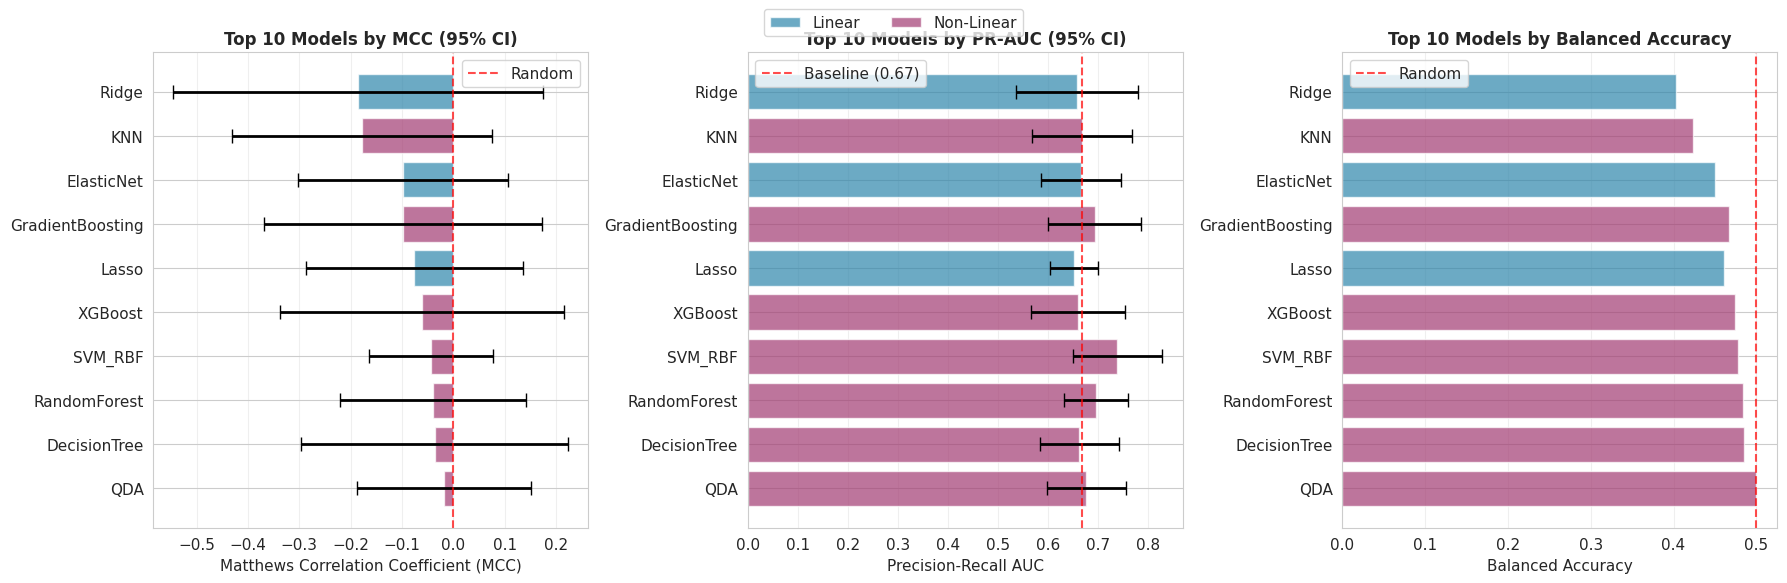

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

top_n = 10
top_models = nested_cv_results_df.head(top_n)

# MCC Plot
ax = axes[0]
y_pos = np.arange(len(top_models))
colors = ['#2E86AB' if t == 'Linear' else '#A23B72' for t in top_models['model_type']]

ax.barh(y_pos, top_models['mean_mcc'], color=colors, alpha=0.7)
ax.errorbar(top_models['mean_mcc'], y_pos, 
            xerr=[top_models['mean_mcc'] - top_models['ci_mcc_lower'],
                  top_models['ci_mcc_upper'] - top_models['mean_mcc']],
            fmt='none', color='black', capsize=5, linewidth=2)

ax.axvline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Random')
ax.set_yticks(y_pos)
ax.set_yticklabels(top_models['model'])
ax.set_xlabel('Matthews Correlation Coefficient (MCC)', fontsize=11)
ax.set_title('Top 10 Models by MCC (95% CI)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(axis='x', alpha=0.3)

# PR-AUC Plot
ax = axes[1]
ax.barh(y_pos, top_models['mean_pr_auc'], color=colors, alpha=0.7)
ax.errorbar(top_models['mean_pr_auc'], y_pos,
            xerr=[top_models['mean_pr_auc'] - top_models['ci_pr_auc_lower'],
                  top_models['ci_pr_auc_upper'] - top_models['mean_pr_auc']],
            fmt='none', color='black', capsize=5, linewidth=2)

baseline_pr = sum(y_train) / len(y_train)
ax.axvline(baseline_pr, color='red', linestyle='--', linewidth=1.5, alpha=0.7, 
           label=f'Baseline ({baseline_pr:.2f})')
ax.set_yticks(y_pos)
ax.set_yticklabels(top_models['model'])
ax.set_xlabel('Precision-Recall AUC', fontsize=11)
ax.set_title('Top 10 Models by PR-AUC (95% CI)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(axis='x', alpha=0.3)

# Balanced Accuracy
ax = axes[2]
ax.barh(y_pos, top_models['mean_bacc'], color=colors, alpha=0.7)
ax.axvline(0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Random')
ax.set_yticks(y_pos)
ax.set_yticklabels(top_models['model'])
ax.set_xlabel('Balanced Accuracy', fontsize=11)
ax.set_title('Top 10 Models by Balanced Accuracy', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(axis='x', alpha=0.3)

legend_elements = [Patch(facecolor='#2E86AB', alpha=0.7, label='Linear'),
                   Patch(facecolor='#A23B72', alpha=0.7, label='Non-Linear')]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.98))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('model_comparison_metrics.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: model_comparison_metrics.png")
plt.show()

### Interpretability and Trade-offs

✓ Saved: interpretability_performance_tradeoff.png


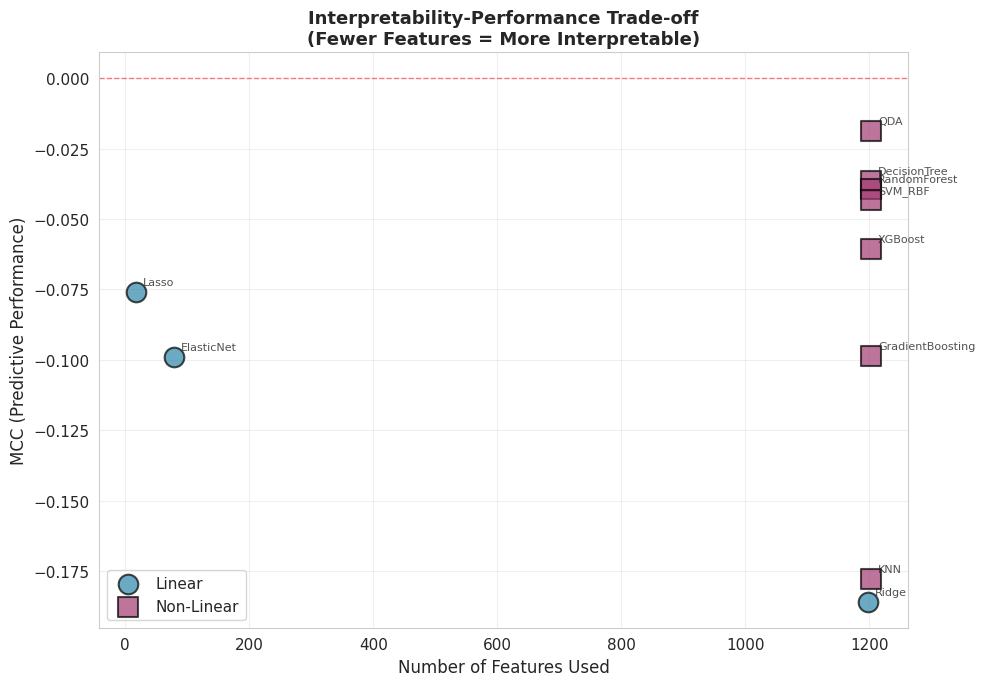

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))

linear_models = nested_cv_results_df[nested_cv_results_df['model_type'] == 'Linear']
nonlinear_models = nested_cv_results_df[nested_cv_results_df['model_type'] == 'Non-Linear']

ax.scatter(linear_models['mean_n_features'], linear_models['mean_mcc'], 
           s=200, alpha=0.7, color='#2E86AB', marker='o', 
           edgecolors='black', linewidth=1.5, label='Linear')

ax.scatter(nonlinear_models['mean_n_features'], nonlinear_models['mean_mcc'], 
           s=200, alpha=0.7, color='#A23B72', marker='s', 
           edgecolors='black', linewidth=1.5, label='Non-Linear')

for idx, row in nested_cv_results_df.head(15).iterrows():
    ax.annotate(row['model'], 
                (row['mean_n_features'], row['mean_mcc']),
                xytext=(5, 5), textcoords='offset points', 
                fontsize=8, alpha=0.8)

ax.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Number of Features Used', fontsize=12)
ax.set_ylabel('MCC (Predictive Performance)', fontsize=12)
ax.set_title('Interpretability-Performance Trade-off\n(Fewer Features = More Interpretable)', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('interpretability_performance_tradeoff.png', dpi=300, bbox_inches='tight')
print("✓ Saved: interpretability_performance_tradeoff.png")
plt.show()

### Sensitivity-Specificity Balanced

✓ Saved: sensitivity_specificity_balance.png


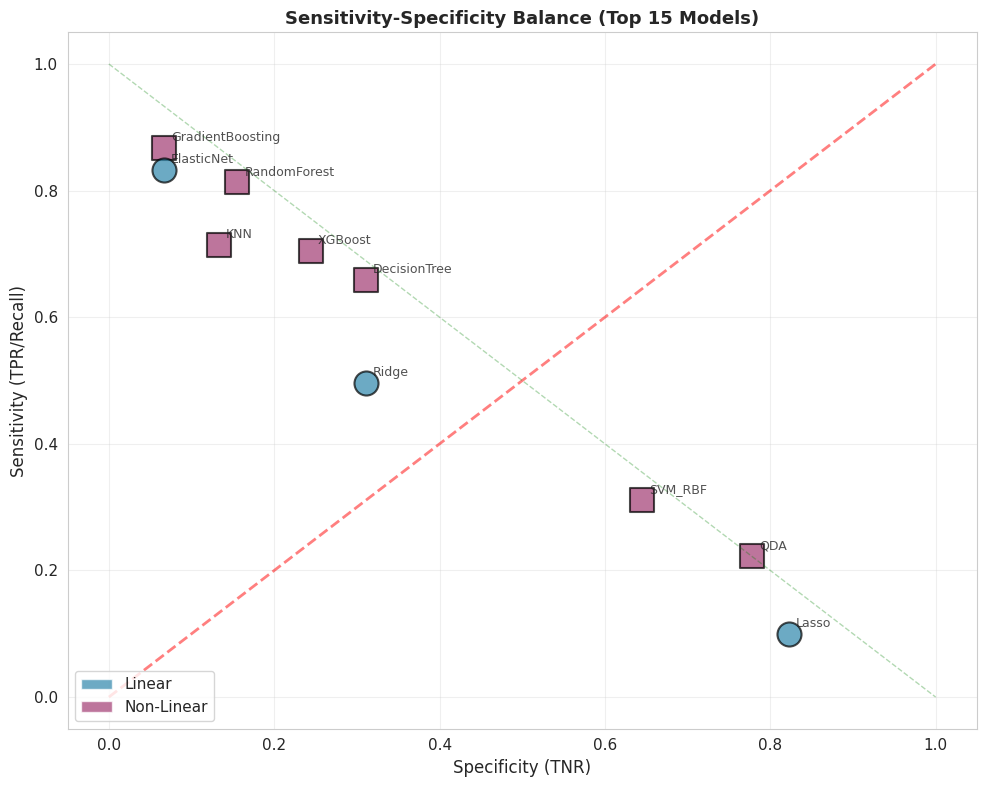

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

for idx, row in nested_cv_results_df.head(15).iterrows():
    color = '#2E86AB' if row['model_type'] == 'Linear' else '#A23B72'
    marker = 'o' if row['model_type'] == 'Linear' else 's'
    
    ax.scatter(row['mean_specificity'], row['mean_sensitivity'], 
               s=300, alpha=0.7, color=color, marker=marker,
               edgecolors='black', linewidth=1.5)
    
    ax.annotate(row['model'], 
                (row['mean_specificity'], row['mean_sensitivity']),
                xytext=(5, 5), textcoords='offset points', 
                fontsize=9, alpha=0.8)

ax.plot([0, 1], [0, 1], 'r--', linewidth=2, alpha=0.5, label='Random Classifier')
ax.plot([0, 1], [1, 0], 'g--', linewidth=1, alpha=0.3)

ax.set_xlabel('Specificity (TNR)', fontsize=12)
ax.set_ylabel('Sensitivity (TPR/Recall)', fontsize=12)
ax.set_title('Sensitivity-Specificity Balance (Top 15 Models)', 
             fontsize=13, fontweight='bold')
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

legend_elements = [
    Patch(facecolor='#2E86AB', alpha=0.7, label='Linear'),
    Patch(facecolor='#A23B72', alpha=0.7, label='Non-Linear')
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=11)

plt.tight_layout()
plt.savefig('sensitivity_specificity_balance.png', dpi=300, bbox_inches='tight')
print("✓ Saved: sensitivity_specificity_balance.png")
plt.show()


### Model Type Comparison

✓ Saved: model_type_comparison_boxplot.png


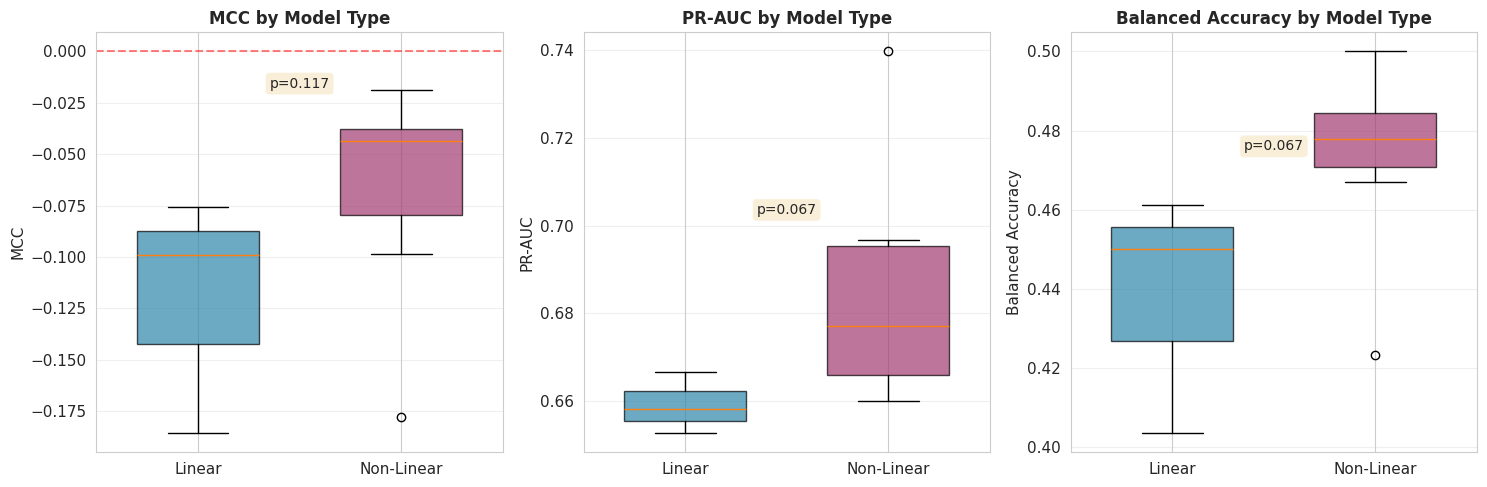

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics_to_plot = [
    ('mean_mcc', 'MCC'),
    ('mean_pr_auc', 'PR-AUC'),
    ('mean_bacc', 'Balanced Accuracy')
]

for idx, (metric, label) in enumerate(metrics_to_plot):
    ax = axes[idx]
    
    data_to_plot = [
        nested_cv_results_df[nested_cv_results_df['model_type'] == 'Linear'][metric].values,
        nested_cv_results_df[nested_cv_results_df['model_type'] == 'Non-Linear'][metric].values
    ]
    
    bp = ax.boxplot(data_to_plot, labels=['Linear', 'Non-Linear'],
                    patch_artist=True, widths=0.6)
    
    colors = ['#2E86AB', '#A23B72']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    if metric == 'mean_mcc':
        ax.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
    
    ax.set_ylabel(label, fontsize=11)
    ax.set_title(f'{label} by Model Type', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    linear_median = np.median(data_to_plot[0])
    nonlinear_median = np.median(data_to_plot[1])
    
    _, p_value = stats.mannwhitneyu(data_to_plot[0], data_to_plot[1], alternative='two-sided')
    
    y_max = max(np.max(data_to_plot[0]), np.max(data_to_plot[1]))
    ax.text(1.5, y_max * 0.95, f'p={p_value:.3f}', 
            ha='center', fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('model_type_comparison_boxplot.png', dpi=300, bbox_inches='tight')
print("✓ Saved: model_type_comparison_boxplot.png")
plt.show()

### Model Family Performance Comparison

In [ ]:
plot_grouped_performance(nested_cv_results_df)


### SMOTE vs No-SMOTE

In [ ]:
quantify_smote_effect(nested_cv_results_df)